# 非同期コミュニケーションを実現するSNSの構成

## システム概要
- テキストや写真・動画によりユーザの非同期コミュニケーションを実現するSNS
- コンテンツ投稿（動画・写真・音声等）、リアルタイムチャット、検索、プッシュ通知、通話、ライブストリーミングなど主要なSNS機能を全て備える

## AWS構成図
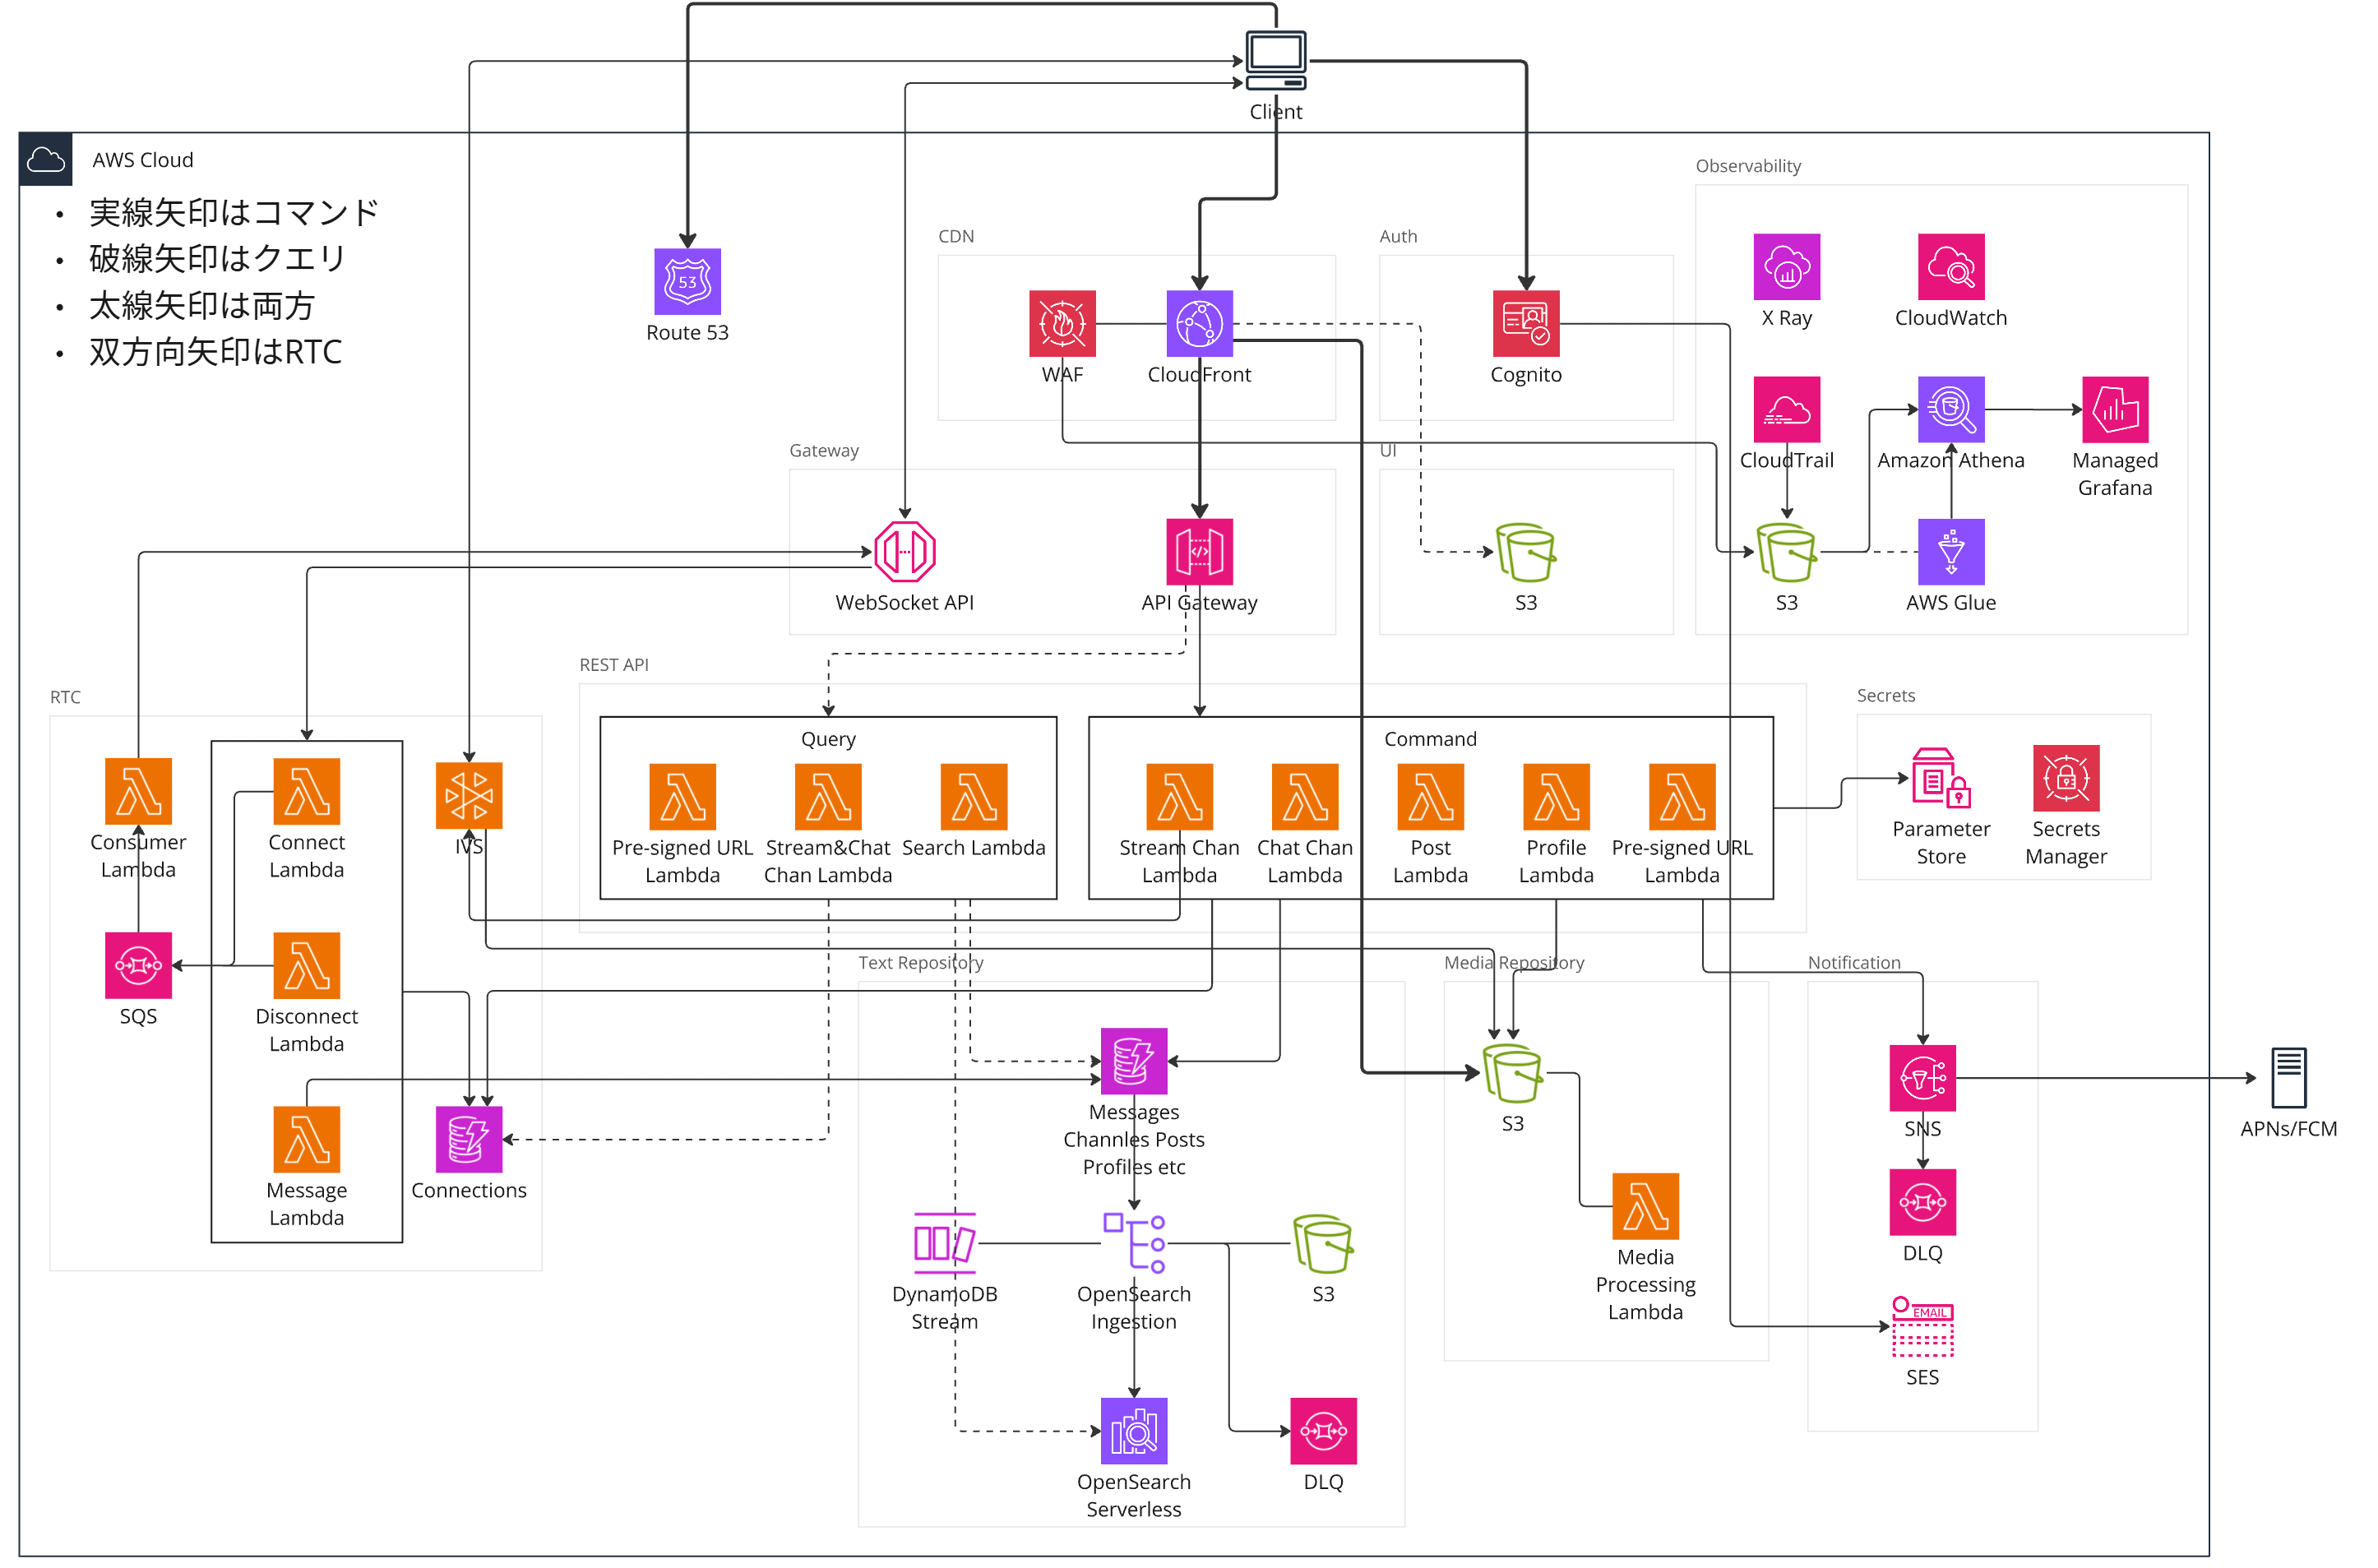

## 構成要素

| 機能 | 役割 | 実装 |
|------|------|------|
| CDN | コンテンツの効率的な配信とアクセス制御 | CloudFrontとWAFを使用してコンテンツ配信を最適化し[SSL証明書の一元管理](https://docs.aws.amazon.com/ja_jp/AmazonCloudFront/latest/DeveloperGuide/cnames-and-https-requirements.html)、[Origin Access Control](https://aws.amazon.com/jp/blogs/news/amazon-cloudfront-introduces-origin-access-control-oac/)ポリシーによる[S3のアクセス制御](https://docs.aws.amazon.com/AmazonCloudFront/latest/DeveloperGuide/private-content-restricting-access-to-s3.html) |
| Gateway | APIリクエストの統合的な制御と管理 | [API GatewayでJWTの一元的な検証](https://docs.aws.amazon.com/ja_jp/apigateway/latest/developerguide/http-api-jwt-authorizer.html)、Lambdaの統合、[マルチリージョンなステートフルエンドポイント](https://github.com/aws-samples/multi-region-websocket-api)、APIバージョン切り替え、負荷対策 |
| UI | フロントエンド配信 | SPAを実装しS3でホスト |
| Auth | ユーザー認証とリソースアクセスに関する各種機能の提供 | CognitoのUser Pool とIdentity Poolを使用した認証基盤。User Poolsではユーザー登録・サインイン・回復の標準的なフローを提供しJWTトークンを発行。Identity Poolを通じて認証済みユーザーに対する一時的なAWSクレデンシャルを発行。これにより、S3やDynamoDBなどのAWSリソースへのアクセス制御を実現。[OAuth 2.0およびOIDCをサポート](https://aws.amazon.com/blogs/security/how-to-use-oauth-2-0-in-amazon-cognito-learn-about-the-different-oauth-2-0-grants/) |
| API | システムの中核となるドメインロジック | Lambdaでサーバーレスアーキテクチャを実現、コマンド処理では、投稿、編集、リアルタイムチャット、通話などの処理を、Media Repository、Text Repository、RTC、Notificationなどのサービスと連携して実現、クエリapiでは、ユーザーが必要とする情報をMedia RepositoryやText Repositoryから取得、[Provisioned Concurrency](https://aws.amazon.com/blogs/aws/new-provisioned-concurrency-for-lambda-functions/#:~:text=Today%20we%20are%20launching%20Provisioned%20Concurrency%2C%20a%20feature,and%20mobile%20backends%2C%20latency-sensitive%20microservices%2C%20or%20synchronous%20APIs.)を用いてコールドスタート対策 |
| Text Repository | テキスト情報の永続化 | DynamoDB, OpenSearch, DynamoDB Stream, S3, DLQで[Zero ETL統合](https://docs.aws.amazon.com/ja_jp/amazondynamodb/latest/developerguide/bp-integration-opensearch.html)、必要に応じて[DAX](https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/DAX.html)による高速化、dynamodbでは[グローバルテーブル設計を行う](https://docs.aws.amazon.com/ja_jp/amazondynamodb/latest/developerguide/bp-global-table-design.html)、messages table、channels table、posts table、profiles tableなどのテーブルが存在 |
| Media Repository | ファイルの永続化 | ユーザーが投稿したメディアファイルなどを[S3に署名付きURLで保存](https://aws.amazon.com/jp/blogs/news/large-size-files-transferring-by-serverless-s3presignedurl-and-clientside-javascript/)、SSE-S3で暗号化、[S3 TriggerでExif除去などの整形](https://wilw.dev/blog/2021/08/28/stripping-exif/) |
| RTC | リアルタイムコミュニケーション | WebSocketやAmazon IVSで[リアルタイムチャット](https://github.com/aws-samples/websocket-chat-application)や[通話機能やライブストリーミング](https://aws.amazon.com/blogs/media/add-multiple-hosts-to-live-streams-with-amazon-ivs/)の提供、録画も可能、マルチリージョン対応 |
| Notification | プッシュ通知の配信 | バックグラウンド等でRTCが利用できない場合、Amazon SNSで配信、[DLQ](https://docs.aws.amazon.com/ja_jp/sns/latest/dg/sns-dead-letter-queues.html)で詳細な分析や再処理 |
| Observability | システム全体の監視と分析 | CloudWatchでシステム性能メトリクス収集・監視, [X-Rayで分散トレーシング](https://github.com/aws-samples/websocket-chat-application?tab=readme-ov-file#aws-x-ray-and-servicemap-integration), CloudTrailで操作履歴の記録・監査, Managed Grafanaで[S3](https://aws.amazon.com/blogs/big-data/visualize-amazon-s3-data-using-amazon-athena-and-amazon-managed-grafana/)や[DynamoDB](https://grafana.com/grafana/plugins/grafana-dynamodb-datasource/)や[OpenSearch](https://grafana.com/grafana/plugins/grafana-opensearch-datasource/)を可視化とダッシュボード作成 |
| Secrets | 機密情報の一元管理 | SecretsManagerでデータベースの認証情報やAPIキーのローテーション管理、[SecretsManagerと統合されているParameterStore](https://docs.aws.amazon.com/ja_jp/systems-manager/latest/userguide/systems-manager-parameter-store.html)で設定値や構成データの管理 |

## 考慮事項

| 分類 | 対策 | 実装 |
|------|------|----------|
| 可用性 | サーバーレス、コンテンツの効率的な配信、再処理、バックアップ、負荷制御 | マネージドサービスをフル活用、CDNによるコンテンツ配信、RTCのマルチリージョン対応、DynamoDBのグローバルテーブル設計、DLQによる再処理や分析、OpenSearch Ingestionに付随するS3のPITR、S3とOpenSearchのレプリケーション、API Gatewayでの負荷対策やWebSocket APIのレプリケーション、一部のLambdaのレプリケーション |
| スケーラビリティ | 自動スケール、データの非正規化、Devops | マネージドサービスをフル活用、DynamoDBやOpenSearchによる書き込みや読み取りに特化したデノーマライズ、AWS CDKを用いたIaCによるGit/CD/CI運用、Clean Architecuterに沿ったプロトコル非依存の抽象化によるインフラ切り替え可能設計 |
| セキュリティ | アクセス制御と認証、データ暗号化、通信暗号化、システム監視 | WAFによるL7での不正アクセス防止、Cognitoによるユーザー認証とアクセス制御の一元管理、SSE-S3による保存データの暗号化、SecretsManagerによるデータベース認証情報やAPIキーなどのローテーション管理、ParameterStoreによる設定値や構成データの一元管理、OACによるS3への直接アクセス制御、アップロードファイルのExif除去、ACMで管理された証明書によるHTTPS/WSSの暗号化通信、CloudWatch/X-Ray/CloudTrailによる統合的な監視と監査 |
